Notebook correspondant à la section 3.2 du rapport, pour la résolution des équations couplées de la précession de Larmor :
\begin{equation}
\left\{
    \begin{aligned}
        \frac{dM_x}{dt} &= \omega M_y \\
        \frac{dM_y}{dt} &= -\omega M_x
    \end{aligned}
\right.
\end{equation}

In [264]:
#imports
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

Physical parameters

In [265]:
M_z0 = tf.constant(0, dtype='float32')
W = 2*np.pi
lamb = 0.3

t_a = -1
t_b = 1

t_0 = 0

Defining the ODE : this function returns the value expected of the derivative, given the independant variable and the value of the function.

In [266]:
def ODE(T, Mz, lamb, W) :
    return lamb*W*(Mz**2-1)

Training parameters

In [267]:
N = 5 #number of samples for the independant variable
training_points = np.linspace(t_a,t_b,N)
training_points = tf.convert_to_tensor(training_points, dtype=tf.float32)

load_model = False
load_filename = "models/2_NN_direct_training_N=10"
save_model = False
save_filename = "models/2_NN_direct_training_N=100"
learning_rate = 5e-4
epochs = 0
display_step = min(max(1,epochs//100), 1000)

Initializing the network

In [268]:
# Network Parameters
n_input = 1     # input layer number of neurons
n_hidden_1 = 4 # 1st layer number of neurons
#n_hidden_2 = 8  # 2nd layer number of neurons
n_output = 1    # output layer number of neurons

#model definition :
model = tf.keras.Sequential([
  tf.keras.layers.Dense(n_hidden_1, activation=tf.nn.sigmoid, input_shape=(n_input,)),  # input shape required
  #tf.keras.layers.Dense(n_hidden_2, activation=tf.nn.sigmoid),
  tf.keras.layers.Dense(n_output)
])

if load_model :
    model = tf.keras.models.load_model(load_filename)

optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate)

Loss function
https://www.tensorflow.org/versions/r2.0/api_docs/python/tf/GradientTape


In [269]:
def loss_function(model, input_tensor, M_z0, lamb, W):

    with tf.GradientTape(persistent=True) as tape:
        tape.watch(input_tensor)
        output = model(input_tensor)
        Mz = M_z0+input_tensor*output[:,0]

    dMz = tape.gradient(Mz, input_tensor)

    e = dMz - ODE(input_tensor, Mz, lamb, W)
    
    print("Mz", Mz.numpy())
    print("dMz", dMz.numpy())
    print("ODE", ODE(input_tensor, Mz, lamb, W).numpy())
    print("e", e.numpy())
    print("e**2", (e**2).numpy())
    print("error", tf.reduce_mean(e**2).numpy())

    print("\nw :",model.layers[0].weights[0].numpy())
    print("b :",model.layers[0].bias.numpy())
    print("v :",model.layers[1].weights[0].numpy())
    print("b2 :",model.layers[1].bias.numpy())
    


    return tf.reduce_mean(e**2)

Gradient of loss

In [270]:
def grad(model, input_tensor, M_z0, lamb, W):
    with tf.GradientTape() as tape:
        loss_value = loss_function(model, input_tensor, M_z0, lamb, W)

    gradient = tape.gradient(loss_value, model.trainable_variables)
    
    print("Grad w",gradient[0].numpy())
    print("Grad b",gradient[1].numpy())
    print("Grad v",gradient[2].numpy())
    print("Grad b2",gradient[3].numpy())

    print("Gradient", gradient)
    print(len(gradient))
    for gr in gradient :
        print(gr.numpy())


    return loss_value, gradient

Training the neural network

In [271]:

losses = []
epochs_displayed = []

for epoch in range(epochs) :
    loss_value, grads = grad(model, training_points, M_z0, lamb, W)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))

    if epoch % display_step == 0 :
        print("Loss after",epoch,"/",epochs,"epochs :",loss_value.numpy())
        losses.append(loss_value.numpy())
        epochs_displayed.append(epoch)

loss_value, grads = grad(model, training_points, M_z0, lamb, W)
print("Final loss after",epochs,"epochs :",loss_value.numpy())
losses.append(loss_value.numpy())
epochs_displayed.append(epochs)

Mz [-0.17580998 -0.04865748  0.         -0.03481315 -0.14812136]
dMz [ 0.32509285  0.17905036  0.01384431 -0.1513617  -0.29740423]
ODE [-1.8266933 -1.8804929 -1.8849556 -1.8826712 -1.8435998]
e [2.151786  2.0595434 1.8987999 1.7313095 1.5461955]
e**2 [4.630183  4.241719  3.605441  2.9974327 2.3907206]
error 3.5730996

w : [[-0.24768037  0.8043213  -0.28434616 -0.20613563]]
b : [0. 0. 0. 0.]
v : [[-0.87000746]
 [-0.63943005]
 [ 0.75611365]
 [ 0.78101254]]
b2 : [0.]
Grad w [[-0.07875107 -0.05899574  0.06852531  0.07060875]]
Grad b [-0.74365723 -0.44028857  0.6415429   0.6723835 ]
Grad v [[1.7275568]
 [1.8231926]
 [1.7242358]
 [1.7313149]]
Grad b2 [3.4998298]
Gradient [<tf.Tensor: shape=(1, 4), dtype=float32, numpy=
array([[-0.07875107, -0.05899574,  0.06852531,  0.07060875]],
      dtype=float32)>, <tf.Tensor: shape=(4,), dtype=float32, numpy=array([-0.74365723, -0.44028857,  0.6415429 ,  0.6723835 ], dtype=float32)>, <tf.Tensor: shape=(4, 1), dtype=float32, numpy=
array([[1.7275568],
  

In [272]:
if save_model :
    model.save(save_filename)

Plot the evolution of loss

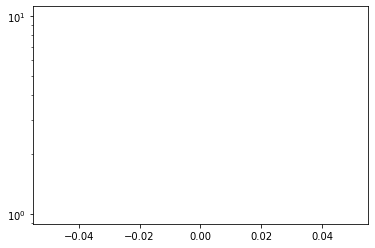

In [273]:
plt.plot(epochs_displayed, losses)
plt.yscale('log')
plt.show()

Compute the analytic solution

In [274]:
def analytic(T, M_z0, lamb, W) :
    K = (M_z0-1) / (M_z0+1)
    Kexp = K*np.exp(2*lamb*W*T)
    Mz_ana = (1+Kexp) / (1-Kexp)
    return Mz_ana

Plot the estimation and the analytic solution

Extreme values of output after : -0.14812136 0.17580998


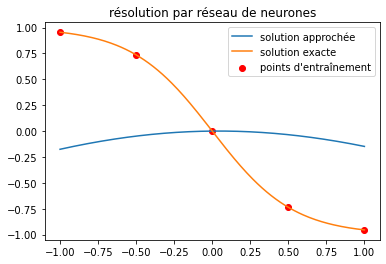

In [275]:
#plot the estimation
nb_plotting_points = 200
plotting_points = np.linspace(t_a,t_b,nb_plotting_points)
plotting_points = tf.convert_to_tensor(plotting_points, dtype=tf.float32)

#neural network estimation
output = model(plotting_points).numpy().reshape((nb_plotting_points))
Mz_NN = M_z0 + (plotting_points-M_z0)*output


print("Extreme values of output after :",min(output), max(output))
#analytic solution
Mz_ana = analytic(plotting_points, M_z0, lamb, W)

#training points
Mz_ana_training = analytic(training_points, M_z0, lamb, W)


plt.plot(plotting_points, Mz_NN, label='solution approchée')
plt.plot(plotting_points, Mz_ana, label='solution exacte')
plt.scatter(training_points, Mz_ana_training, label="points d'entraînement", color='red')

plt.legend()
plt.title('résolution par réseau de neurones')
plt.show()
